In [1]:
%matplotlib inline
from matplotlib import style

style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()


# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:

query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
query_date

datetime.date(2016, 8, 23)

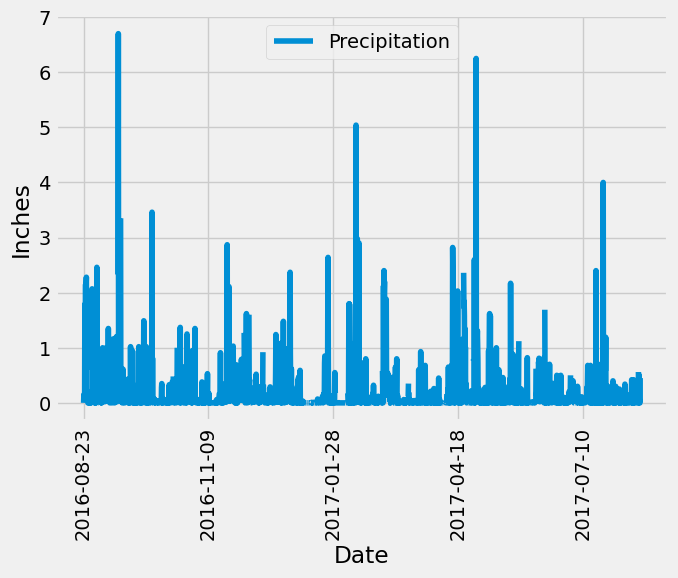

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recentdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
# Calculate the date one year from the last date in data set.
Year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= Year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names

df = pd.DataFrame(precip_data, columns=['date', 'precipitation'])
# Sort the dataframe by date
df = df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='date', y='precipitation', figsize=(7, 6), legend=True)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend(['Precipitation'])
plt.grid(True)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df["precipitation"].agg(['count', 'mean', 'std', 'min', 'max'])
percentiles = df["precipitation"].quantile([0.25, 0.5, 0.75]).to_dict()

# Add the percentiles to the summary statistics
summary_statistics['25%'] = percentiles[0.25]
summary_statistics['50%'] = percentiles[0.5]
summary_statistics['75%'] = percentiles[0.75]
summary_df = summary_statistics.to_frame(name='precipitation')
summary_df

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
max,6.700000
25%,0.000000
50%,0.020000
75%,0.130000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station.station.distinct())
    
total_stations.count()

9

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
stations = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

stations
    


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
most_active_station_id = most_active_station.station

temperature_stats = (session.query(func.min(Measurement.tobs),
                                   func.max(Measurement.tobs),
                                   func.avg(Measurement.tobs))
                     .filter(Measurement.station == most_active_station_id)
                     .first())
temperature_stats

(54.0, 85.0, 71.66378066378067)

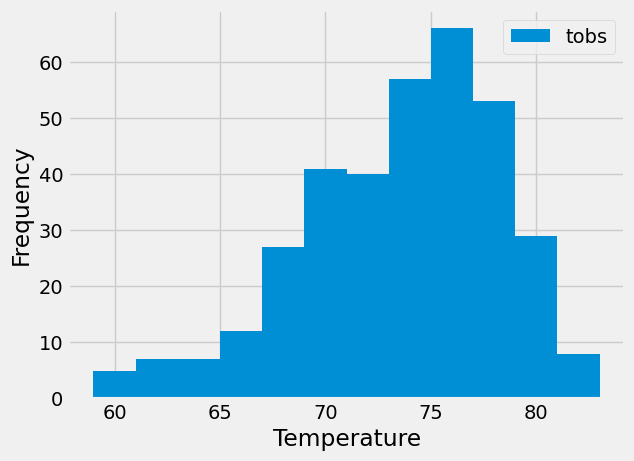

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

recentdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
# Calculate the date one year from the last date in data set.
Year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)


temperature_data = (session.query(Measurement.tobs)
                    .filter(Measurement.station == most_active_station_id)
                    .filter(Measurement.date >= Year_ago)
                    .all())

# Extract temperature values
temperatures = [temp[0] for temp in temperature_data]

# Plot the results as a histogram
plt.hist(temperatures, bins=12)
plt.legend(['tobs'])
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()


# Close Session

In [19]:
# Close Session
session.close()